In [1]:
import yaml

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import os
import sys
from gnn_cp.data.data_manager import GraphDataManager
from gnn_cp.models.graph_models import GCN, GAT, APPNPNet, SAGE
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch is running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda


In [2]:
config_file_dir = "config/config.yaml"
results_dir = "results"

In [3]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T

dataset_obj = PygNodePropPredDataset(name='ogbn-arxiv',
                                     transform=T.ToSparseTensor())

dataset = dataset_obj[0]
dataset.adj_t = dataset.adj_t.to_symmetric()
split_idx = dataset_obj.get_idx_split()

In [4]:
from original_example_withoutBN import GCN, SAGE

models_path = os.path.join(results_dir, "models")

def_num_layers =3
def_hidden_channels = 64
def_dropout =0.5
def_lr =0.01


model = GCN(dataset_obj.num_features, def_hidden_channels,
                    dataset_obj.num_classes, def_num_layers,
                    def_dropout).to(device)

model.load_state_dict(torch.load(os.path.join(models_path, "gcn_model_run0.pt")))

<All keys matched successfully>

In [5]:
@torch.no_grad()
def get_output(model, data):
    model.eval()
    out = model(data.x, data.adj_t)
    return out

all_logits = get_output(model.cpu(), dataset)
accuracy = accuracy_score(y_pred=all_logits.argmax(dim=1).numpy(), y_true=dataset.y.reshape(-1).numpy())
y_true = dataset.y.reshape(-1)

In [6]:
calib_fraction = 0.5

lambda_vals = np.arange(0, 1.51, 0.05).round(3)
coverage_values = np.arange(start=accuracy.round(2), stop=1.0, step=0.005).round(3)
fixed_neigh_coef = 0.55
selected_coverage = coverage_values[len(coverage_values)//2]


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric,
}

In [7]:
edge_index = PygNodePropPredDataset(name='ogbn-arxiv')[0].edge_index
edge_index = torch_geometric.utils.sort_edge_index(edge_index)

normal_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True)])
all_scores = normal_cp.get_scores_from_logits(logits=all_logits)
test_scores = all_scores[split_idx['test']]
test_mask = F.one_hot(y_true[split_idx['test']]).bool()

normal_cp_results = normal_cp.shuffle_metrics_over_coverage(test_scores, test_mask, coverage_values, metrics_dict=metrics_dict)


overal_mixing_result = []
for lambda_val in lambda_vals:
    mixed_cp = GraphCP(
        transformation_sequence=[cp_t.TPSTransformation(softmax=True), cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=edge_index, n_vertices=dataset.x.shape[0]), cp_t.APSTransformation(softmax=False)])

    mixed_all_scores = mixed_cp.get_scores_from_logits(logits=all_logits.to(device))
    mixed_test_scores = mixed_all_scores[split_idx['test']]

    mixed_cp_results = mixed_cp.shuffle_metrics_over_coverage(mixed_test_scores, test_mask, coverage_values, metrics_dict=metrics_dict)
    mixed_cp_results["lambda"] = lambda_val
    overal_mixing_result.append(mixed_cp_results)

overal_mixing_result = pd.concat(overal_mixing_result)

In [9]:
print("dataset = OGBN-arxiv")
homophily = torch_geometric.utils.homophily(edge_index, y_true)
print("homophily = ", homophily)

dataset = OGBN-arxiv
homophily =  0.6550830602645874


In [19]:
all_softmaxes = F.softmax(all_logits, dim=1)

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

def kl_divergence(p, q):
    return torch.sum(p * torch.log(p / q), dim=1)

In [49]:
js_divs = js_divergence(all_softmaxes[edge_index[0]], all_softmaxes[edge_index[1]])
js_threshold = 0.1
modified_edge_index = edge_index.T[js_divs < js_threshold].T

In [53]:
dataset

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598])

In [50]:
edge_index.shape

torch.Size([2, 1166243])

In [51]:
modified_edge_index.shape

torch.Size([2, 737732])

In [54]:
torch_geometric.utils.homophily(modified_edge_index, y_true)

0.7710550427436829

In [55]:
edge_index = PygNodePropPredDataset(name='ogbn-arxiv')[0].edge_index
edge_index = torch_geometric.utils.sort_edge_index(edge_index)

normal_cp = GraphCP(
    transformation_sequence=[cp_t.APSTransformation(softmax=True)])
all_scores = normal_cp.get_scores_from_logits(logits=all_logits)
test_scores = all_scores[split_idx['test']]
test_mask = F.one_hot(y_true[split_idx['test']]).bool()

normal_cp_results = normal_cp.shuffle_metrics_over_coverage(test_scores, test_mask, coverage_values, metrics_dict=metrics_dict)


overal_mixing_result = []
for lambda_val in lambda_vals:
    mixed_cp = GraphCP(
        transformation_sequence=[cp_t.APSTransformation(softmax=True), cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=modified_edge_index, n_vertices=dataset.x.shape[0])])

    mixed_all_scores = mixed_cp.get_scores_from_logits(logits=all_logits.to(device))
    mixed_test_scores = mixed_all_scores[split_idx['test']]

    mixed_cp_results = mixed_cp.shuffle_metrics_over_coverage(mixed_test_scores, test_mask, coverage_values, metrics_dict=metrics_dict)
    mixed_cp_results["lambda"] = lambda_val
    overal_mixing_result.append(mixed_cp_results)

overal_mixing_result = pd.concat(overal_mixing_result)

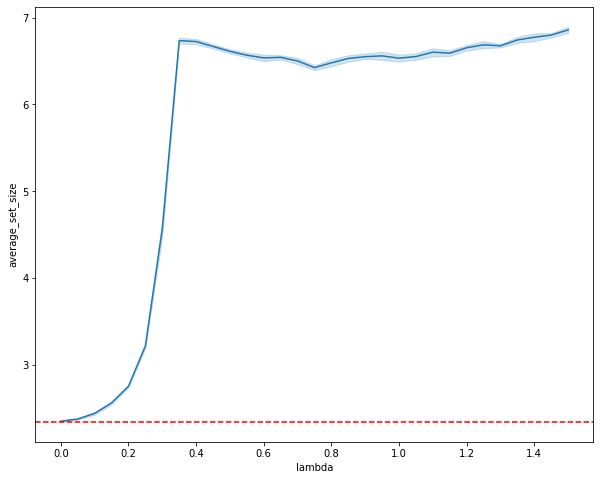

In [58]:
selected_coverage = round((1 + 2*accuracy) / 3, 3)

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=overal_mixing_result.loc[overal_mixing_result["coverage_guarantee"] == 0.81], x="lambda", y="average_set_size", ax=ax)
ax.axhline(y=normal_cp_results.loc[normal_cp_results["coverage_guarantee"] == 0.81, "average_set_size"].mean(), color="red", linestyle="--")

(1.3, 4.0)

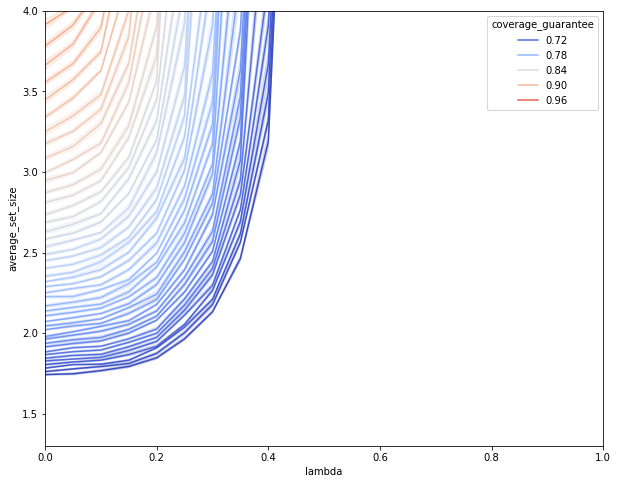

In [59]:
selected_coverage = round((1 + 2*accuracy) / 3, 3)

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=overal_mixing_result, x="lambda", y="average_set_size", hue="coverage_guarantee",  ax=ax, palette=sns.color_palette("coolwarm", as_cmap=True))

plt.xlim(0, 1)
plt.ylim(1.3, 4)

In [107]:
dataset

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598])

In [111]:
torch_geometric.utils.sort_edge_index(edge_index)

tensor([[     0,      0,      1,  ..., 169341, 169342, 169342],
        [ 52893,  93487, 141692,  ..., 163274,  27824, 158981]])

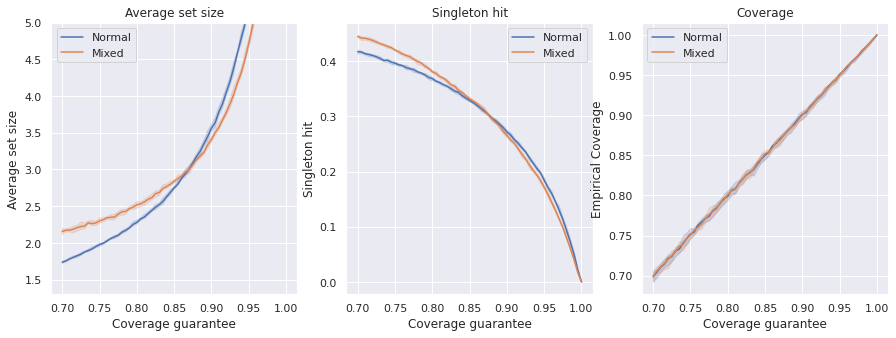

In [106]:
sns.set()
f, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="average_set_size", errorbar="pi", ax=axs[0], label="Normal")
sns.lineplot(data=overal_mixing_result.loc[overal_mixing_result["lambda"]==0.6], x="coverage_guarantee", y="average_set_size", errorbar="pi", ax=axs[0], label="Mixed")

sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="singleton_hit", errorbar="pi", ax=axs[1], label="Normal")
sns.lineplot(data=overal_mixing_result.loc[overal_mixing_result["lambda"]==0.6], x="coverage_guarantee", y="singleton_hit", errorbar="pi", ax=axs[1], label="Mixed")

sns.lineplot(data=normal_cp_results, x="coverage_guarantee", y="empi_coverage", errorbar="pi", ax=axs[2], label="Normal")
sns.lineplot(data=overal_mixing_result.loc[overal_mixing_result["lambda"]==0.6], x="coverage_guarantee", y="empi_coverage", errorbar="pi", ax=axs[2], label="Mixed")

axs[0].set_title("Average set size")
axs[1].set_title("Singleton hit")
axs[2].set_title("Coverage")

axs[0].set_xlabel("Coverage guarantee")
axs[1].set_xlabel("Coverage guarantee")
axs[2].set_xlabel("Coverage guarantee")

axs[0].set_ylabel("Average set size")
axs[1].set_ylabel("Singleton hit")
axs[2].set_ylabel("Empirical Coverage")

axs[0].set_ylim(1.3, 5)
plt.show()


In [79]:
coverage_values = [0.85, 0.9, 0.95]

normal_mean = normal_cp_results.loc[normal_cp_results["coverage_guarantee"] == coverage_values[0]].mean()
normal_std = normal_cp_results.loc[normal_cp_results["coverage_guarantee"] == coverage_values[0]].std()

mixed_mean = overal_mixing_result.loc[overal_mixing_result["coverage_guarantee"] == coverage_values[0]].groupby("lambda").mean()
mixed_std = overal_mixing_result.loc[overal_mixing_result["coverage_guarantee"] == coverage_values[0]].groupby("lambda").std()

lambda065mean = mixed_mean.loc[0.6]
lambda065std = mixed_std.loc[0.6]

lambda025mean = mixed_mean.loc[0.25]
lambda025std = mixed_std.loc[0.25]



In [80]:
normal_mean

attempt               4.500000
empi_coverage         0.850741
average_set_size      2.416703
singleton_hit         0.341692
coverage_guarantee    0.850000
dtype: float64

In [81]:
normal_std

attempt               3.027650
empi_coverage         0.003724
average_set_size      0.014685
singleton_hit         0.001609
coverage_guarantee    0.000000
dtype: float64

In [82]:
lambda025mean

attempt               4.500000
empi_coverage         0.850329
average_set_size      2.594667
singleton_hit         0.398087
coverage_guarantee    0.850000
Name: 0.25, dtype: float64

In [83]:
lambda025std

attempt               3.027650
empi_coverage         0.002849
average_set_size      0.019025
singleton_hit         0.003474
coverage_guarantee    0.000000
Name: 0.25, dtype: float64

In [84]:
lambda065mean

attempt               4.500000
empi_coverage         0.850045
average_set_size      2.417836
singleton_hit         0.423801
coverage_guarantee    0.850000
Name: 0.6, dtype: float64

In [85]:
lambda065std

attempt               3.027650
empi_coverage         0.002206
average_set_size      0.025607
singleton_hit         0.002982
coverage_guarantee    0.000000
Name: 0.6, dtype: float64